<a href="https://colab.research.google.com/github/peta-m175/rabbit_challenge/blob/master/deep_learning/day3/exercises/3_1_simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [21]:
import sys
sys.path.append('/content/drive/My Drive/rabbit_challenge/DNN_code_colab_ver200425')

# simple RNN
### バイナリ加算

iters:0
Loss:1.8990793247689373
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 0 1 1 1 0 0]
7 + 85 = 255
------------
iters:100
Loss:1.2493808535646123
Pred:[0 1 0 1 0 0 1 1]
True:[1 0 1 0 0 1 1 0]
120 + 46 = 83
------------
iters:200
Loss:0.9064200889775069
Pred:[0 0 0 0 0 0 1 0]
True:[0 0 1 0 1 0 0 0]
7 + 33 = 2
------------
iters:300
Loss:0.8121338369538366
Pred:[0 0 0 1 0 0 1 1]
True:[0 0 0 1 0 0 0 0]
8 + 8 = 19
------------
iters:400
Loss:0.9378703825158563
Pred:[1 1 0 1 0 0 1 0]
True:[1 1 0 0 0 1 1 0]
125 + 73 = 210
------------
iters:500
Loss:0.9849911700240461
Pred:[0 1 1 0 1 0 1 1]
True:[1 0 1 0 1 1 1 0]
56 + 118 = 107
------------
iters:600
Loss:1.2403627647431672
Pred:[1 0 0 1 1 1 1 0]
True:[1 0 1 0 0 0 1 1]
119 + 44 = 158
------------
iters:700
Loss:1.1247376592103449
Pred:[0 0 0 1 0 0 0 1]
True:[1 0 0 0 1 0 0 0]
122 + 14 = 17
------------
iters:800
Loss:0.7136931573957801
Pred:[0 0 0 0 0 0 0 1]
True:[1 0 0 1 0 1 0 1]
73 + 76 = 1
------------
iters:900
Loss:0.8084869838497479
Pred:[0 0 0

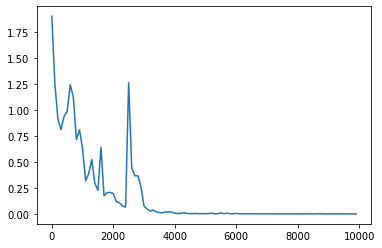

In [22]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

def d_tanh(x):
    return 1/(np.cosh(x) ** 2)


# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 2
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
#W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
#W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
#W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He
#W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
#W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
#W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
        #z[:,t+1] = functions.relu(u[:,t+1])
        #z[:,t+1] = np.tanh(u[:,t+1]) 
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] weight_init_stdやlearning_rate, hidden_layer_sizeを変更してみよう


## [try] 重みの初期化方法を変更してみよう
Xavier, He

## [try] 中間層の活性化関数を変更してみよう
ReLU(勾配爆発を確認しよう)<br>
tanh(numpyにtanhが用意されている。導関数をd_tanhとして作成しよう)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

iters:0
Loss:1.0261798423431616
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 0 1 0 1]
95 + 6 = 0
------------
iters:100
Loss:1.0304170992012145
Pred:[1 1 1 1 1 0 1 1]
True:[1 0 1 0 0 1 1 0]
123 + 43 = 251
------------
iters:200
Loss:0.9773668714889887
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 0 1 0 0]
1 + 99 = 0
------------
iters:300
Loss:0.9927961642607963
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 0 1 0 1 1]
77 + 30 = 255
------------
iters:400
Loss:1.033356489252251
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 0 1 1 1 0]
120 + 22 = 0
------------
iters:500
Loss:1.0035421674587608
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 1 1 0 0]
11 + 113 = 0
------------
iters:600
Loss:1.1394358668796856
Pred:[1 1 1 1 1 1 1 1]
True:[0 0 1 0 0 1 1 0]
10 + 28 = 255
------------
iters:700
Loss:0.8482924420090276
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 1 1 1 1 0]
96 + 30 = 255
------------
iters:800
Loss:0.9331377891045649
Pred:[1 0 0 0 0 0 0 0]
True:[0 1 0 0 0 0 0 0]
64 + 0 = 128
------------
iters:900
Loss:1.0108344392566653
Pred:[1 1 1 1 

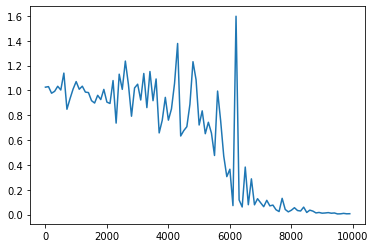

In [23]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

def d_tanh(x):
    return 1/(np.cosh(x) ** 2)


# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 2
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
#W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
#W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
#W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He
#W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
#W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
#W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
        #z[:,t+1] = functions.relu(u[:,t+1])
        #z[:,t+1] = np.tanh(u[:,t+1]) 
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

iters:0
Loss:0.7694608178034485
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 0 1 1 1 1 1]
34 + 61 = 255
------------
iters:100
Loss:0.9935160192280147
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 0 0 0 1]
70 + 107 = 0
------------
iters:200
Loss:1.1602478809994377
Pred:[1 1 1 1 1 1 1 1]
True:[1 1 0 0 0 0 0 1]
125 + 68 = 255
------------
iters:300
Loss:1.0323251191923999
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 0 0 0 1 1]
87 + 44 = 255
------------
iters:400
Loss:1.0187563532584447
Pred:[0 1 1 1 1 0 0 1]
True:[0 0 1 1 1 1 0 0]
16 + 44 = 121
------------
iters:500
Loss:1.0217929565694872
Pred:[1 1 1 1 1 0 1 1]
True:[1 0 0 0 1 1 0 1]
52 + 89 = 251
------------
iters:600
Loss:1.0775640331462035
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 0 1 1 1]
124 + 43 = 0
------------
iters:700
Loss:1.0137276213578688
Pred:[0 0 0 1 1 1 0 1]
True:[0 1 1 1 1 0 0 1]
106 + 15 = 29
------------
iters:800
Loss:0.8701666354693552
Pred:[0 0 0 0 0 0 0 1]
True:[0 1 0 0 0 0 0 0]
64 + 0 = 1
------------
iters:900
Loss:1.1404489471929953
Pred:[1 1

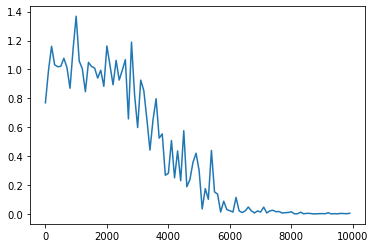

In [24]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

def d_tanh(x):
    return 1/(np.cosh(x) ** 2)


# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 2
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
#W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
#W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
#W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
#W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
#W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
#W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
        #z[:,t+1] = functions.relu(u[:,t+1])
        #z[:,t+1] = np.tanh(u[:,t+1]) 
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

iters:0
Loss:1.4495565064216198
Pred:[1 1 1 1 1 1 0 1]
True:[0 1 1 1 0 1 1 1]
50 + 69 = 253
------------
iters:100
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 0 1 1 1 1]
17 + 126 = 0
------------


/content/drive/My Drive/rabbit_challenge/DNN_code_colab_ver200425/common/functions.py:6: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


iters:200
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 0 1 0 1]
64 + 21 = 0
------------
iters:300
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 0 1 1 0 0]
71 + 69 = 0
------------
iters:400
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 1 0 1 1]
29 + 78 = 0
------------
iters:500
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 1 1 1 0]
77 + 1 = 0
------------
iters:600
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 1 1 1 1]
109 + 66 = 0
------------
iters:700
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 1 0 0 1 1]
76 + 71 = 0
------------
iters:800
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 1 1 1 1]
95 + 80 = 0
------------
iters:900
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 0 0 1 1 0]
23 + 111 = 0
------------
iters:1000
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 1 0 0 0 1]
50 + 95 = 0
------------
iters:1100
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 1 1 1 0]
120 + 54 = 0
------------
iters:1200
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[1 1 0 0 0 1 0 1]
73 + 124 = 0
------------
iter

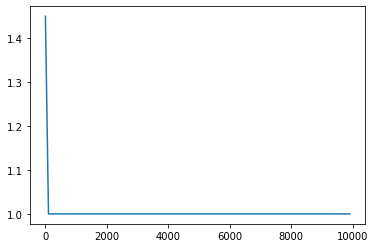

In [25]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

def d_tanh(x):
    return 1/(np.cosh(x) ** 2)


# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 2
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
#W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
#W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
#W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He
#W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
#W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
#W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        #z[:,t+1] = functions.sigmoid(u[:,t+1])
        z[:,t+1] = functions.relu(u[:,t+1])
        #z[:,t+1] = np.tanh(u[:,t+1]) 
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

iters:0
Loss:1.4942606397851363
Pred:[1 1 1 1 0 0 1 0]
True:[0 1 1 1 1 1 1 0]
44 + 82 = 242
------------
iters:100
Loss:0.9167141286518717
Pred:[0 1 0 0 1 0 1 1]
True:[1 0 0 0 0 0 1 1]
44 + 87 = 75
------------
iters:200
Loss:1.403043852437137
Pred:[0 1 1 0 1 1 0 1]
True:[0 0 0 1 1 0 1 0]
15 + 11 = 109
------------
iters:300
Loss:0.9137507734970177
Pred:[1 0 0 0 0 0 1 0]
True:[0 1 1 0 0 0 1 0]
2 + 96 = 130
------------
iters:400
Loss:1.2920080414138737
Pred:[0 0 1 1 0 0 0 1]
True:[0 1 0 0 1 1 1 1]
66 + 13 = 49
------------
iters:500
Loss:1.0733408459990186
Pred:[0 0 0 0 0 0 0 1]
True:[0 1 0 1 0 1 1 1]
1 + 86 = 1
------------
iters:600
Loss:0.7781087794826216
Pred:[0 0 0 0 0 0 1 0]
True:[0 0 1 0 1 0 1 0]
8 + 34 = 2
------------
iters:700
Loss:1.1423451358025114
Pred:[0 0 0 0 1 0 0 1]
True:[0 1 1 1 1 0 1 1]
100 + 23 = 9
------------
iters:800
Loss:0.9560638042242114
Pred:[1 1 0 1 1 1 0 0]
True:[0 1 1 0 0 0 0 0]
19 + 77 = 220
------------
iters:900
Loss:0.4873249390249614
Pred:[0 1 1 0 0 

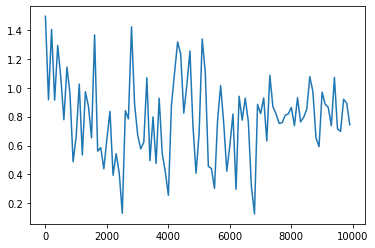

In [26]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

def d_tanh(x):
    return 1/(np.cosh(x) ** 2)


# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 2
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
#W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
#W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
#W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He
#W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
#W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
#W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        #z[:,t+1] = functions.sigmoid(u[:,t+1])
        #z[:,t+1] = functions.relu(u[:,t+1])
        z[:,t+1] = np.tanh(u[:,t+1]) 
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        #delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()